In [1]:
from torch.utils.data import dataset
from tqdm import tqdm
import network
import utils
import os, sys
import random
import argparse
import numpy as np
import pandas as pd

from torch.utils import data
from datasets import VOCSegmentation, Cityscapes, cityscapes
from torchvision import transforms as T
#from torchinfo import summary
from metrics import StreamSegMetrics

import torch
import torch.nn as nn

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from glob import glob

Backbone HRNet Pretrained weights at: ./checkpoints/hrnetv2_32_model_best_epoch96.pth, only usable for HRNetv2-32


In [2]:
PATH_root = '/psi/home/li_s1/data/Season'
PATH_model = '/psi/home/li_s1/data/Season/pretrained'
PATH_data = '/psi/home/li_s1/data/Season/images_400_224/100k'
PATH_name = '/psi/home/li_s1/DeepLearning2021/dataset/names'
PATH_seg = '/psi/home/li_s1/data/Season/classids_400_224_better'

train_path = os.path.join(PATH_data, "train")
val_path = os.path.join(PATH_data, "val")
test_path = os.path.join(PATH_data, "test")
data_set_paths = {'train': train_path, 'val': val_path, 'test': test_path}
df_names_weather = pd.read_csv(os.path.join(PATH_root, 'both_name_weather.csv'))
df_names_weather.head()

,dataset,name,weather
0,train,0000f77c-6257be58.jpg,clear
1,train,0000f77c-62c2a288.jpg,clear
2,train,0000f77c-cb820c98.jpg,clear
3,train,0001542f-5ce3cf52.jpg,clear
4,train,0001542f-7c670be8.jpg,clear


In [19]:
def segmentation(split, weather):
    # Setup dataloader
    input_path = data_set_paths[split]
    image_files = []
    for ext in ['png', 'jpeg', 'jpg', 'JPEG']:
        files = glob(os.path.join(input_path, '**/*.%s'%(ext)), recursive=True)
        if len(files)>0:
            image_files.extend(files)
            print(len(image_files))
    print(len(image_files))
    names_weather = df_names_weather[(df_names_weather['weather']==weather) & (df_names_weather['dataset']==split)].name.values
    names_weather = [os.path.join(input_path, n) for n in names_weather]
    print(len(names_weather))
    names_final = list(set(names_weather).intersection(set(image_files)))
    print(len(names_final))
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device: %s" % device)

    CKPT_PATH = os.path.join(PATH_model, 'best_deeplabv3plus_mobilenet_cityscapes_os16.pth')

    # Set up model
    model = network.modeling.__dict__['deeplabv3plus_mobilenet'](num_classes=19, output_stride=16)
    utils.set_bn_momentum(model.backbone, momentum=0.01)

    checkpoint = torch.load(CKPT_PATH, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state"])
    model = nn.DataParallel(model)
    model.to(device)
    del checkpoint
    
    decode_fn = Cityscapes.decode_target
    transform = T.Compose([
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
                ])
    
    with torch.no_grad():
        model = model.eval()
        for img_path in tqdm(names_final):
            img_name = os.path.basename(img_path).split('.')[0]
            img = Image.open(img_path).convert('RGB')
            img = transform(img).unsqueeze(0) # To tensor of NCHW
            img = img.to(device)

            pred = model(img).max(1)[1].cpu().numpy()[0] # HW
            classid_preds = Image.fromarray(pred.astype('uint8'))
            colorized_preds = decode_fn(pred).astype('uint8')
            colorized_preds = Image.fromarray(colorized_preds)
            
            classid_preds.save(os.path.join(PATH_seg, 'classids', split, weather, img_name+'_seg_class.png'))
            colorized_preds.save(os.path.join(PATH_seg, 'colormaps', split, weather, img_name+'_seg_color.png'))

In [23]:
segmentation('val', 'clear')

10000
10000
5346
5346
Device: cuda


100%|██████████| 5346/5346 [09:54<00:00,  9.00it/s]


## Test evaluation

10000
Device: cpu


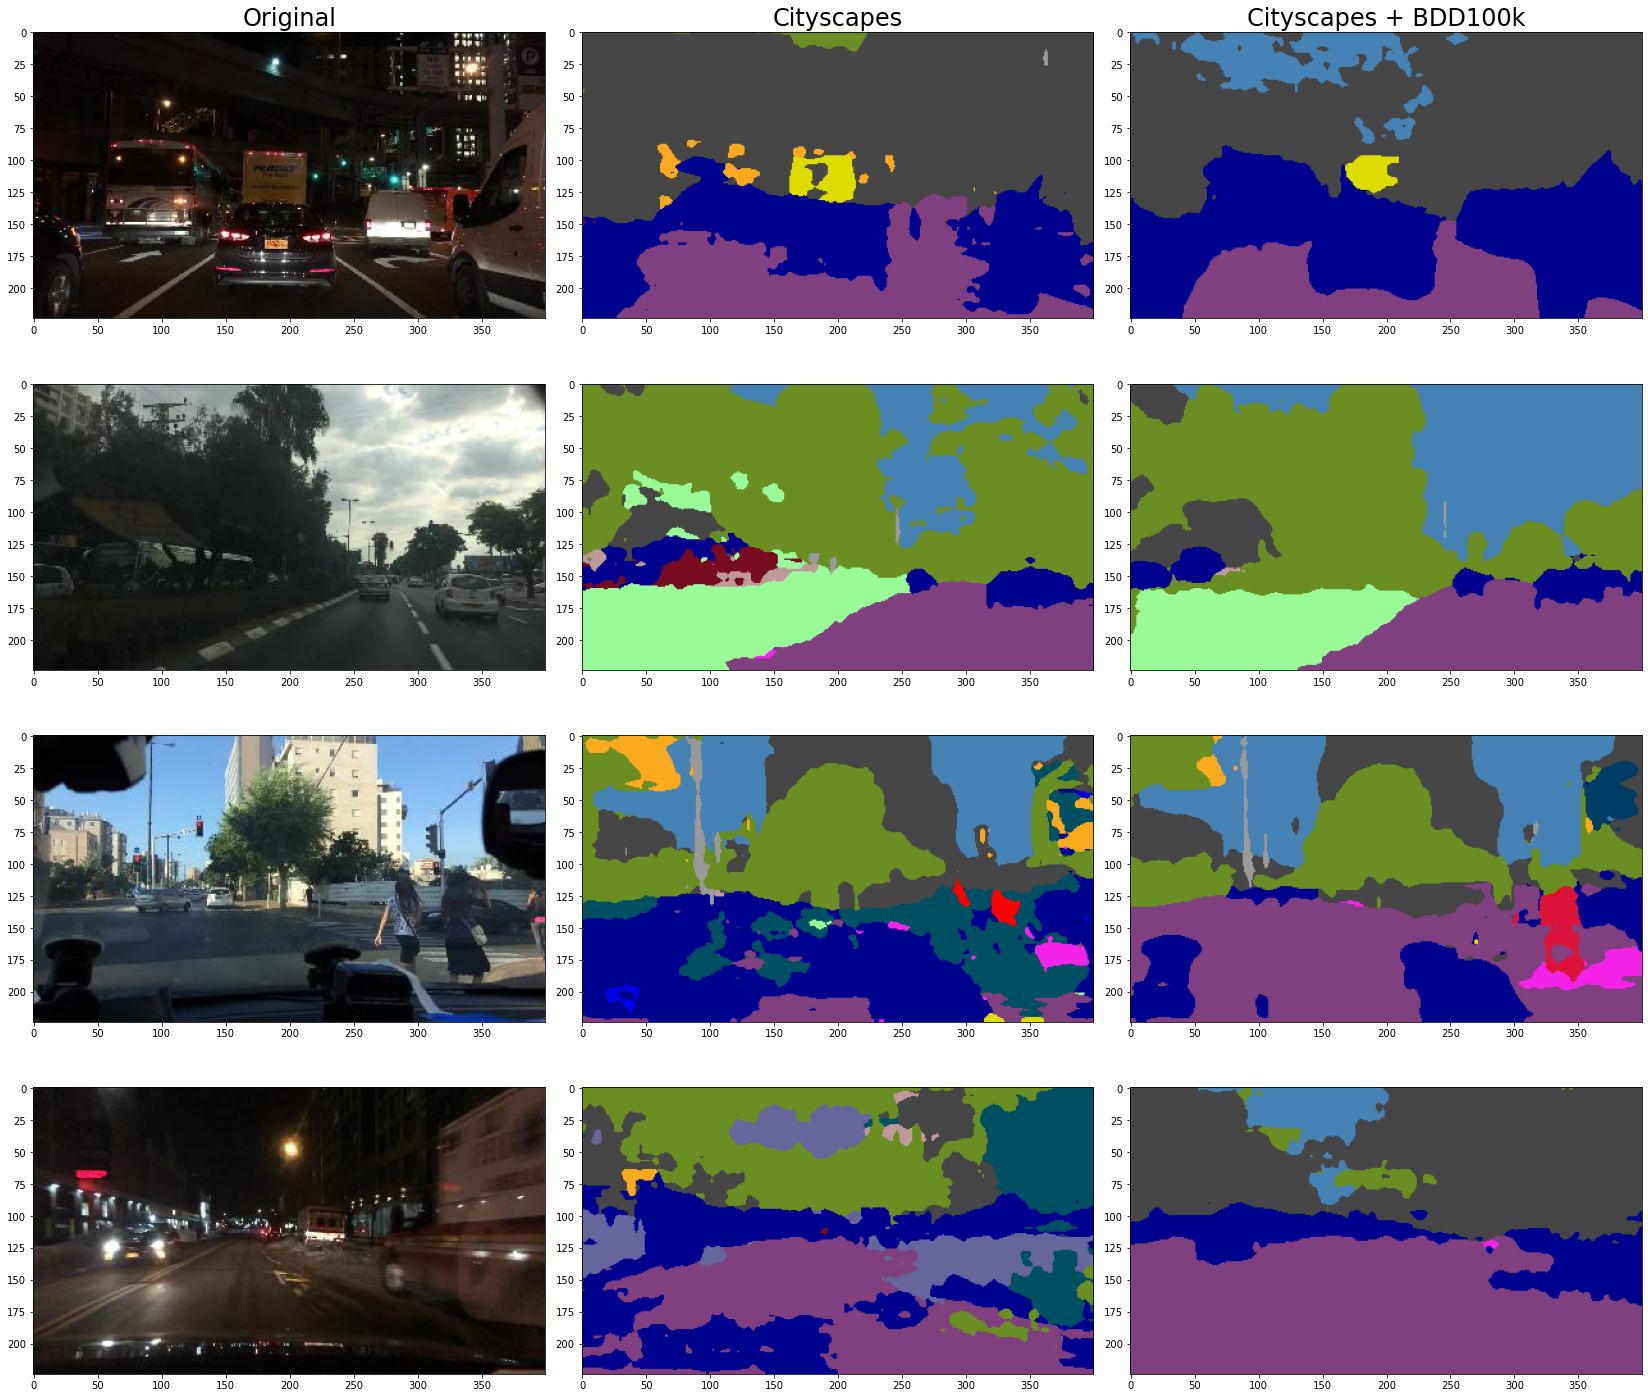

In [11]:
image_files = []
for ext in ['png', 'jpeg', 'jpg', 'JPEG']:
    files = glob(os.path.join(val_path, '**/*.%s'%(ext)), recursive=True)
    if len(files)>0:
        image_files.extend(files)
print(len(image_files))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: %s" % device)

CKPT_PATH1 = os.path.join(PATH_model, 'best_deeplabv3plus_mobilenet_cityscapes_os16.pth')
CKPT_PATH2 = os.path.join(PATH_model, 'latest_deeplabv3plus_mobilenet_BDD100k_os16.pth')

# Set up model
model1 = network.modeling.__dict__['deeplabv3plus_mobilenet'](num_classes=19, output_stride=16)
utils.set_bn_momentum(model1.backbone, momentum=0.01)

checkpoint1 = torch.load(CKPT_PATH1, map_location=torch.device('cpu'))
model1.load_state_dict(checkpoint1["model_state"])
model1 = nn.DataParallel(model1)
model1.to(device)
del checkpoint1

model2 = network.modeling.__dict__['deeplabv3plus_mobilenet'](num_classes=19, output_stride=16)
utils.set_bn_momentum(model2.backbone, momentum=0.01)

checkpoint2 = torch.load(CKPT_PATH2, map_location=torch.device('cpu'))
model2.load_state_dict(checkpoint2["model_state"])
model2 = nn.DataParallel(model2)
model2.to(device)
del checkpoint2
    
decode_fn = Cityscapes.decode_target
transform = T.Compose([
                T.ToTensor(),
                T.CenterCrop((224,400)),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
            ])
# if opts.save_val_results_to is not None:
#     os.makedirs(opts.save_val_results_to, exist_ok=True)
#save_val_results_to = '/psi/home/li_s1/data/Season/seg_result/classids/train'

cols = ['Original', 'Cityscapes', 'Cityscapes + BDD100k']
fig, axs = plt.subplots(4,3, figsize=(23,20))
with torch.no_grad():
    model1 = model1.eval()
    model2 = model2.eval()
    for count, img_path in enumerate(image_files[:4]):
        img_name = os.path.basename(img_path).split('.')[0]
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)
        axs[count, 0].imshow(img_array)
        #print(transform(img).shape)
        img = transform(img).unsqueeze(0) # To tensor of NCHW
        img = img.to(device)
        #print(img)
        
        out = model1(img)
#         print('input shape:', img.shape)
#         print('output shape:', out.shape)
        pred = model1(img).max(1)[1].cpu().numpy()[0] # HW
        #classid_preds = Image.fromarray(pred.astype('uint8'))
        colorized_preds = decode_fn(pred).astype('uint8')
        axs[count, 1].imshow(colorized_preds)
        #colorized_preds = Image.fromarray(colorized_preds)
        
        #if save_val_results_to:
            #classid_preds.save(os.path.join(save_val_results_to, img_name+'_seg_classid.png'))
        #colorized_preds.save(os.path.join(PATH_root, 'img_name+_seg_color.png'))
        
        out = model2(img)
#         print('input shape:', img.shape)
#         print('output shape:', out.shape)
        pred = model2(img).max(1)[1].cpu().numpy()[0] # HW
        #classid_preds = Image.fromarray(pred.astype('uint8'))
        colorized_preds = decode_fn(pred).astype('uint8')
        axs[count, 2].imshow(colorized_preds)
    
for ax, col in zip(axs[0], cols):
    ax.set_title(col, fontsize=24)
fig.tight_layout()

In [7]:
len(val_set_names)

46

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[ 8  8  8 ... 10 10 10]
 [ 8  8  8 ... 10 10 10]
 [ 8  8  8 ... 10 10 10]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


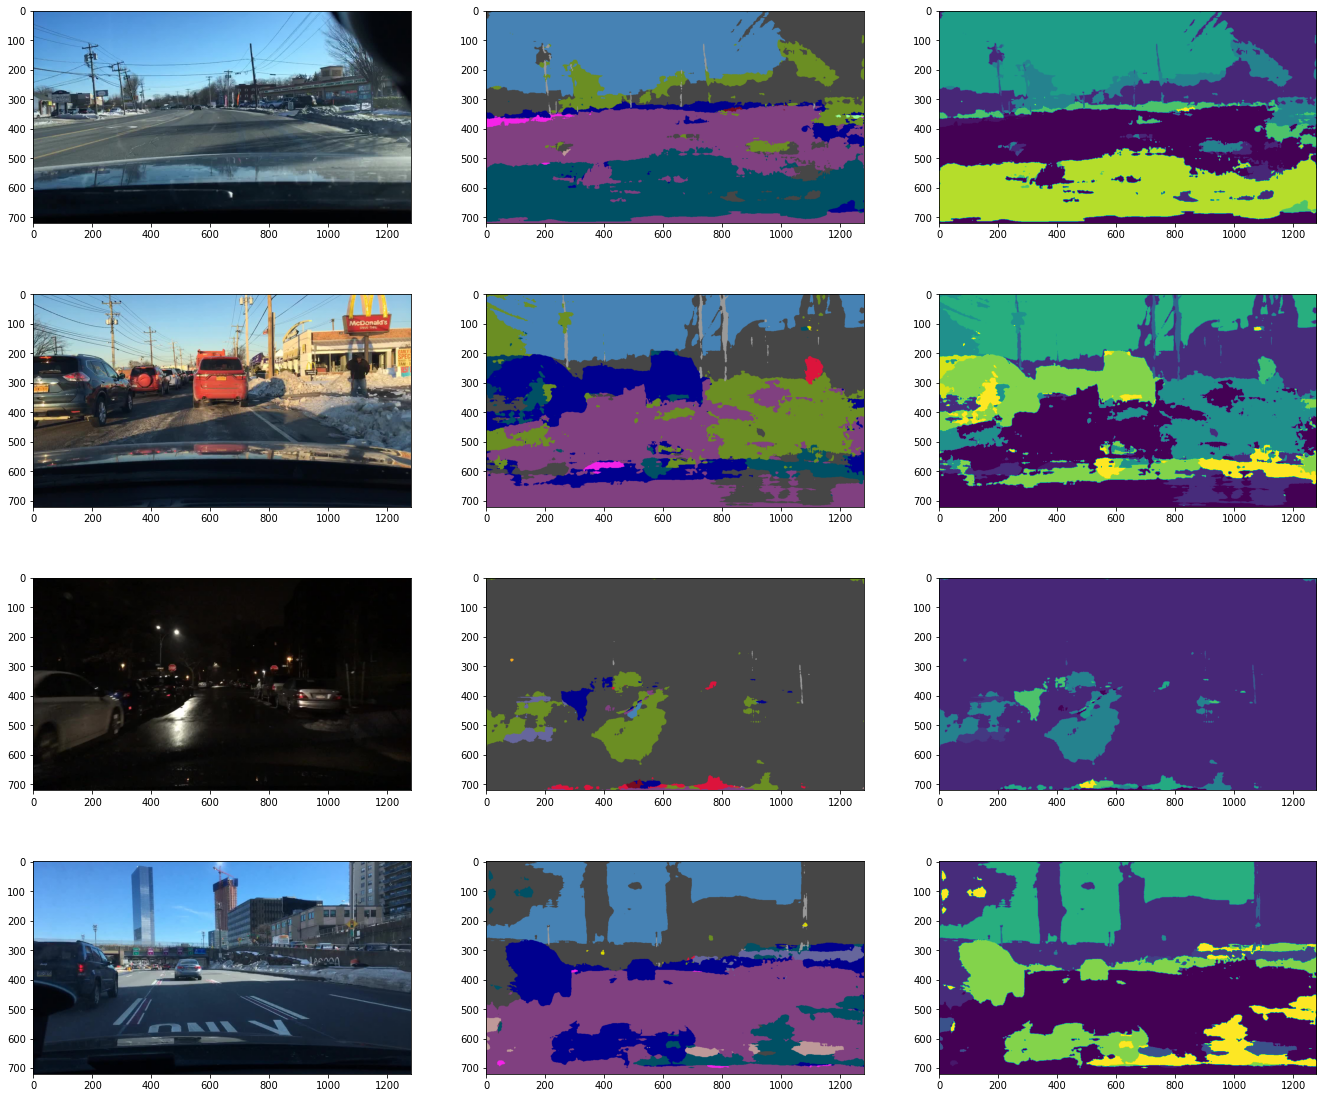

In [8]:
fig, axs = plt.subplots(4,3, figsize=(23,20))

seg_files_id = glob(os.path.join(PATH_seg, 'classids','val','snowy', '**/*.png'), recursive=True)
seg_files_color = glob(os.path.join(PATH_seg, 'colormaps','val','snowy', '**/*.png'), recursive=True)
for count, img_path in enumerate(seg_files_color[:4]):
    img_name = os.path.basename(img_path).split('.')[0].split('_')[0]
    img = Image.open(img_path).convert('RGB')
    img_array = np.array(img)
    axs[count, 1].imshow(img_array)
    
    img_orig_path = os.path.join(val_path, img_name+'.jpg')
    img_orig = Image.open(img_orig_path).convert('RGB')
    img_orig_array = np.array(img_orig)
    axs[count, 0].imshow(img_orig_array)
    
    img_id_name = img_name + '_seg_class.png'
    img_id_path = os.path.join(PATH_seg, 'classids','val','snowy', img_id_name)
    img_id = Image.open(img_id_path)
    img_id_array = np.array(img_id)
    axs[count, 2].imshow(img_id_array)
    print(np.unique(img_id_array))

In [1]:
!git branch

* feature/Discriminator
  master
  segmentation
